In [1]:
# Random Forest Classification Script for Mobile Price Dataset
# Implements data exploration, preprocessing, hyperparameter tuning, and evaluation
# Includes outlier handling, feature importance, holdout vs. CV comparison, parameter sensitivity,
# preprocessing strategy comparison, runtime analysis, report-ready summaries, and trend identification

# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import time
import os
%matplotlib inline



Dataset Shape: (2000, 21)

First 5 Rows:
    battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15

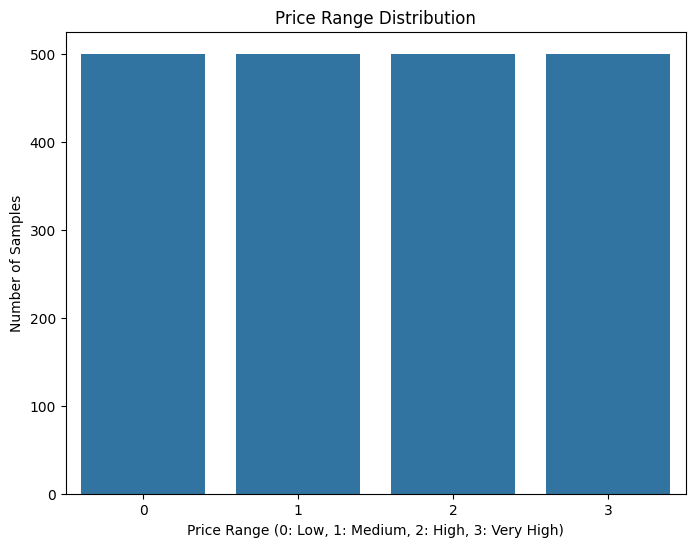


Missing Values:
 Series([], dtype: int64)

Feature Statistics:
        battery_power       blue  clock_speed     dual_sim           fc  \
count    2000.000000  2000.0000  2000.000000  2000.000000  2000.000000   
mean     1238.518500     0.4950     1.522250     0.509500     4.309500   
std       439.418206     0.5001     0.816004     0.500035     4.341444   
min       501.000000     0.0000     0.500000     0.000000     0.000000   
25%       851.750000     0.0000     0.700000     0.000000     1.000000   
50%      1226.000000     0.0000     1.500000     1.000000     3.000000   
75%      1615.250000     1.0000     2.200000     1.000000     7.000000   
max      1998.000000     1.0000     3.000000     1.000000    19.000000   

            four_g   int_memory        m_dep    mobile_wt      n_cores  ...  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000  ...   
mean      0.521500    32.046500     0.501750   140.249000     4.520500  ...   
std       0.499662    18.145715

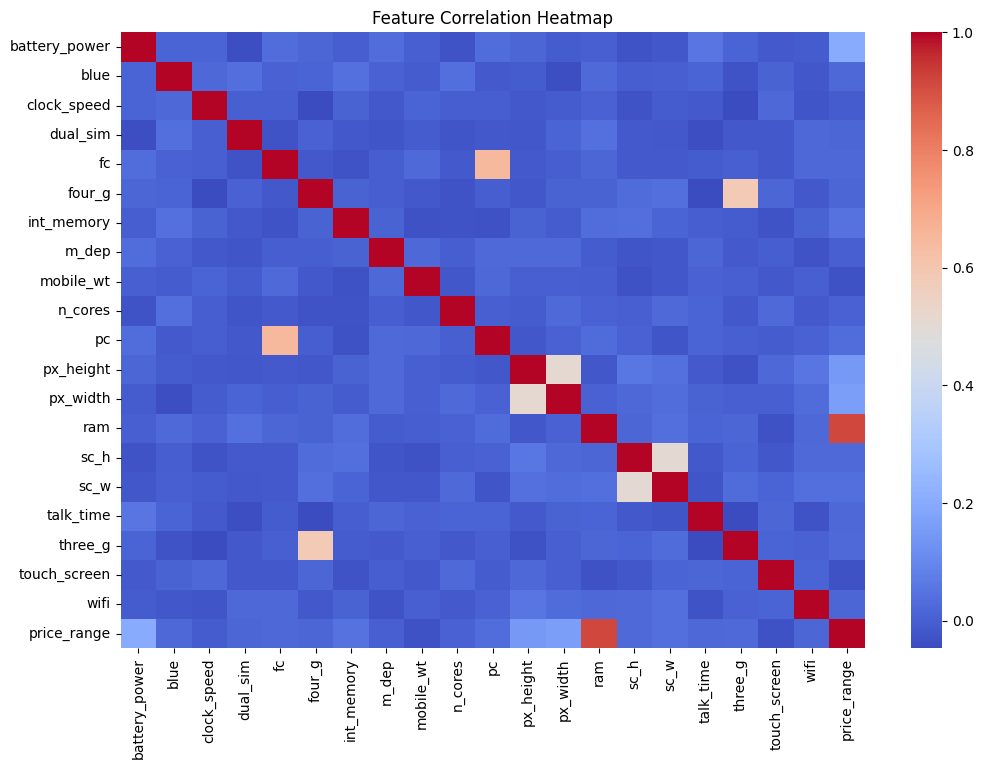


Outlier Analysis:
battery_power: 0 outliers


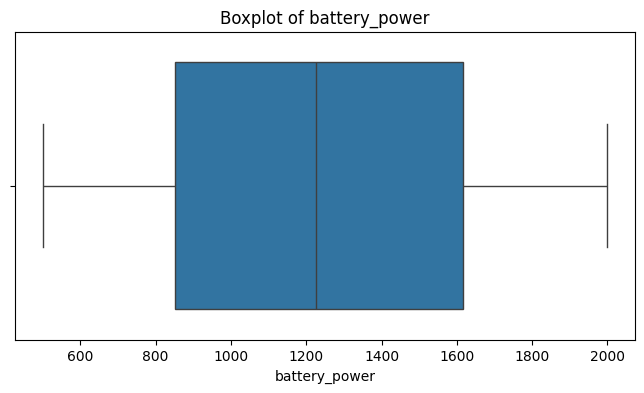

blue: 0 outliers


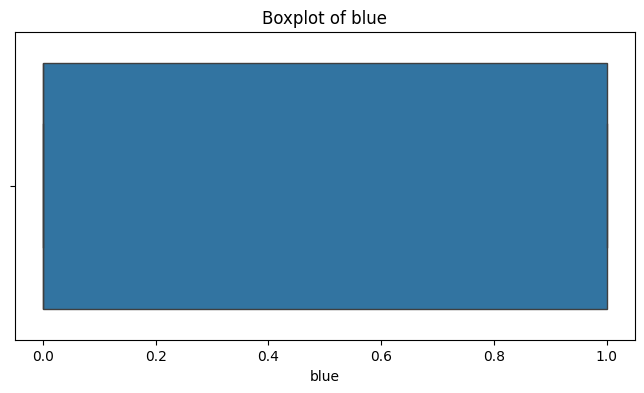

clock_speed: 0 outliers


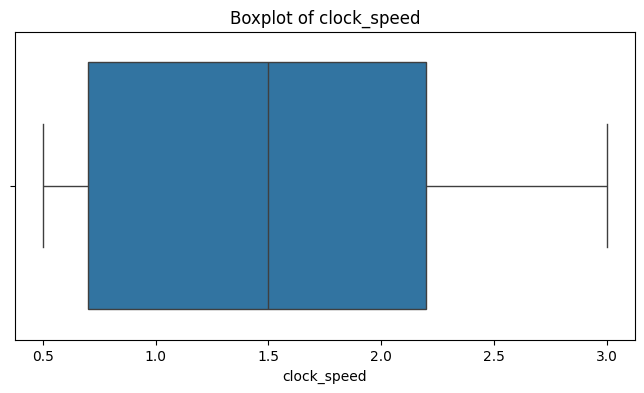

dual_sim: 0 outliers


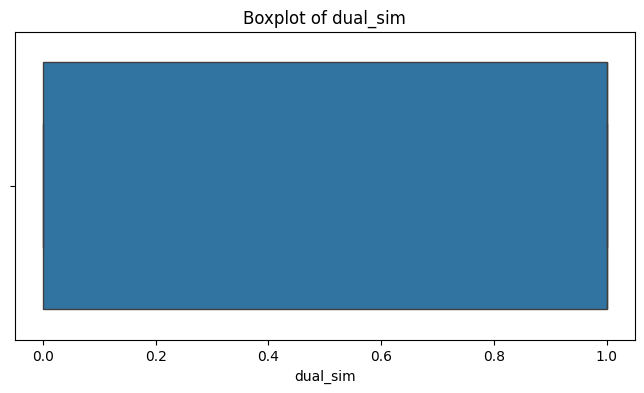

fc: 18 outliers


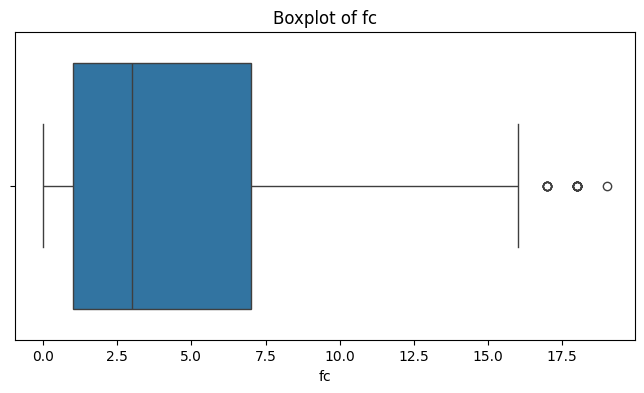

four_g: 0 outliers


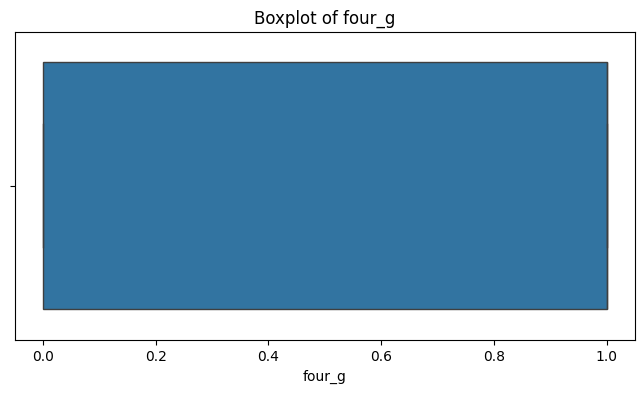

int_memory: 0 outliers


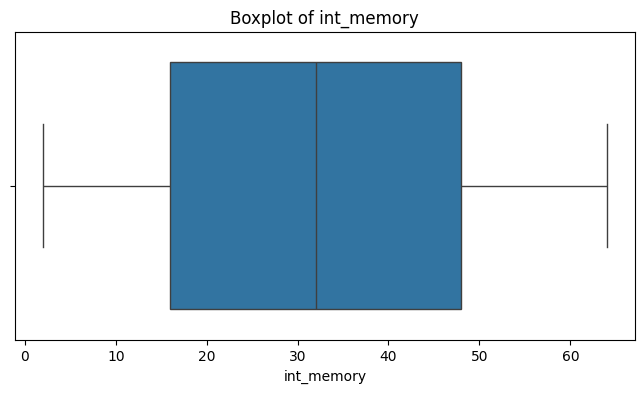

m_dep: 0 outliers


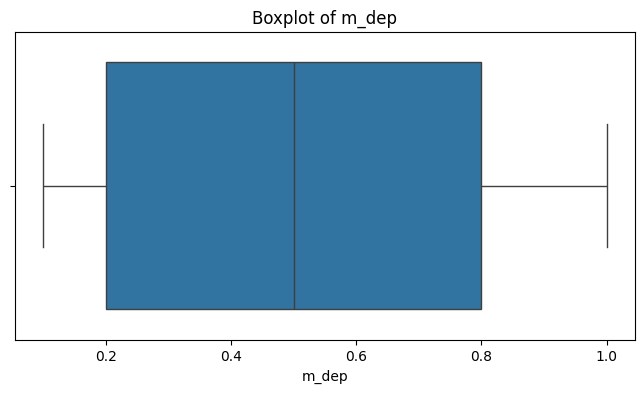

mobile_wt: 0 outliers


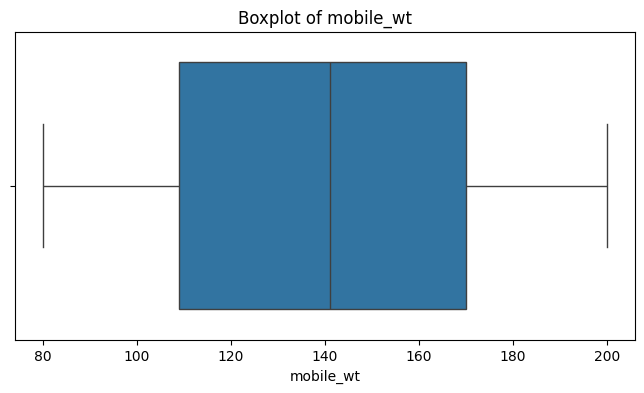

n_cores: 0 outliers


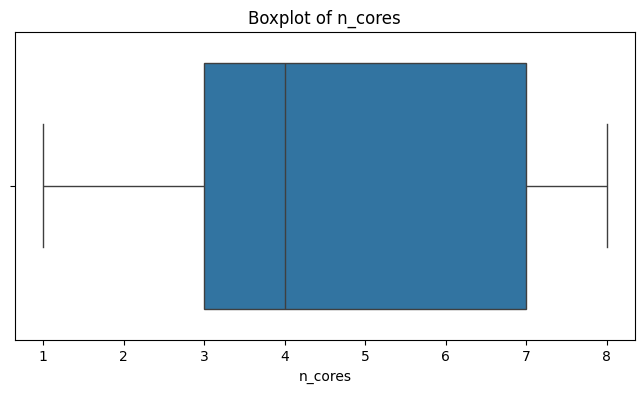

pc: 0 outliers


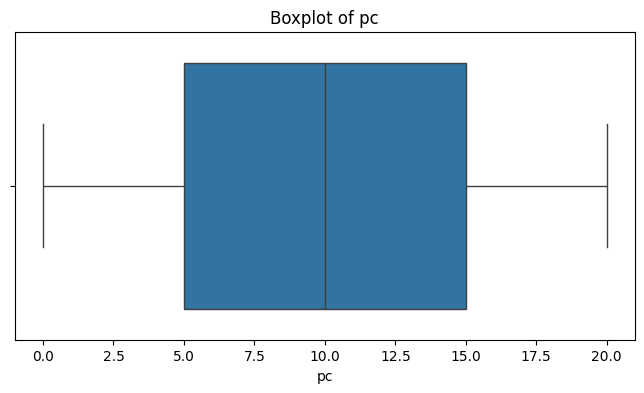

px_height: 2 outliers


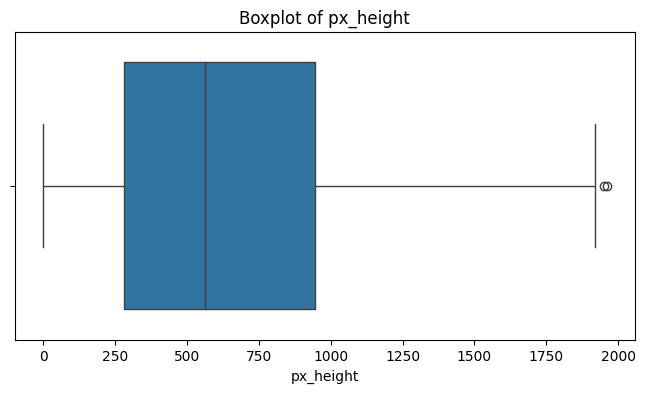

px_width: 0 outliers


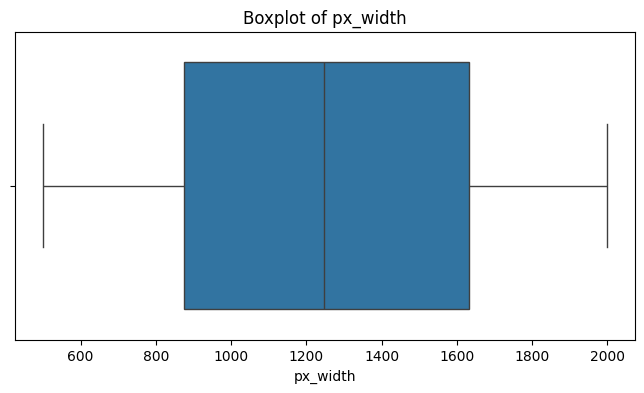

ram: 0 outliers


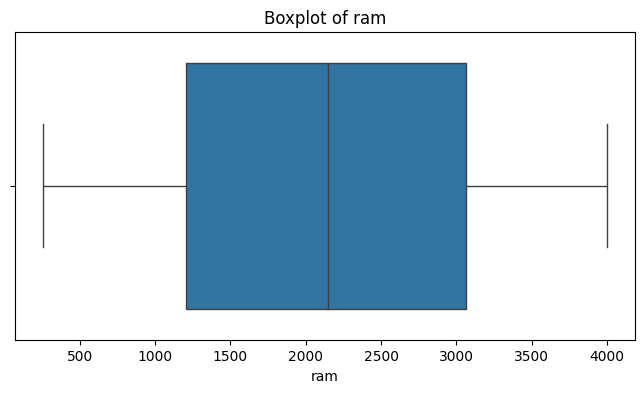

sc_h: 0 outliers


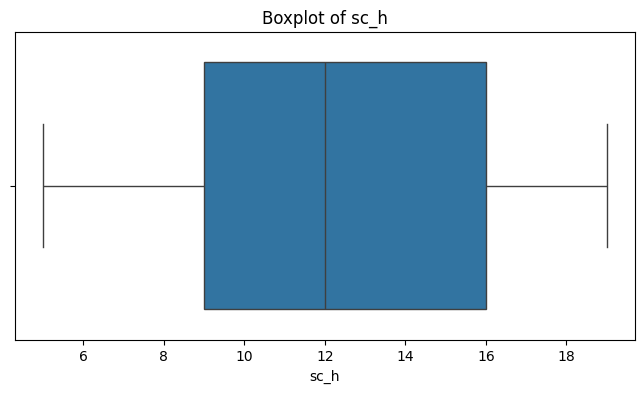

sc_w: 0 outliers


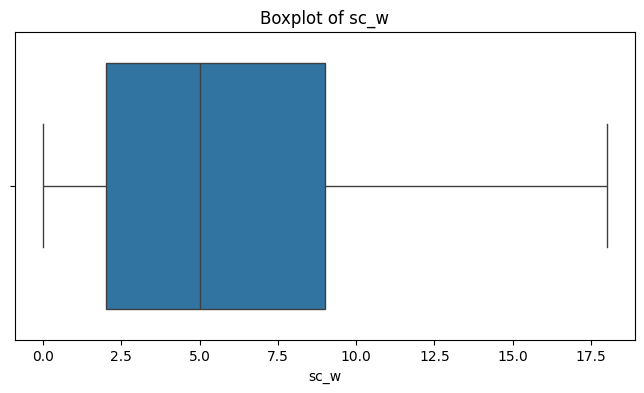

talk_time: 0 outliers


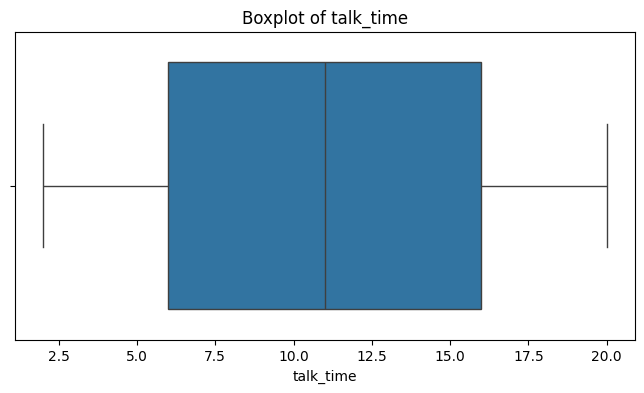

three_g: 477 outliers


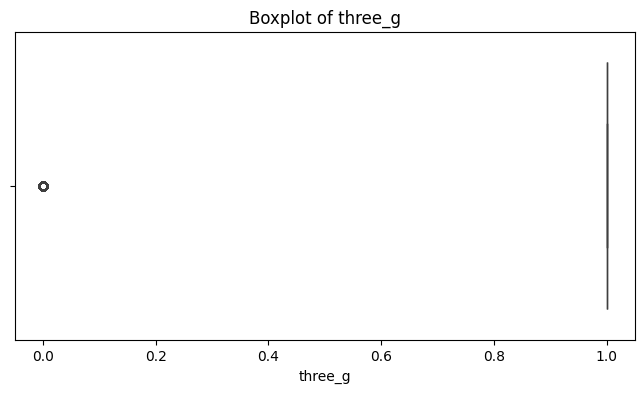

touch_screen: 0 outliers


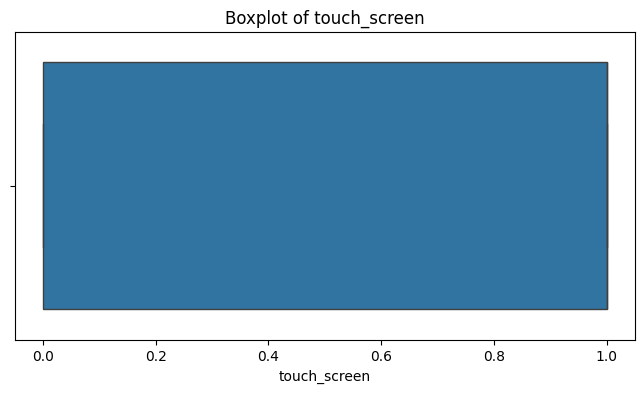

wifi: 0 outliers


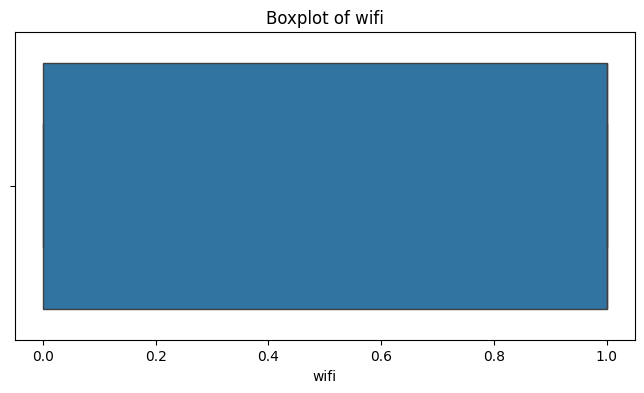

In [2]:

# Cell 2: Data Exploration
def detect_outliers(df, feature_cols):
    """Detect and visualize outliers using IQR method for numerical features."""
    print("\nOutlier Analysis:")
    for col in feature_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        print(f"{col}: {len(outliers)} outliers")
        # Visualize outliers with boxplot
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.savefig(f'outliers_{col}_mobile.png')
        plt.show()

def explore_dataset(df):
    """Explore dataset structure, class distribution, missing values, and outliers.
    Saves visualizations (class distribution, correlation heatmap, boxplots) for the report.
    """
    print("\nDataset Shape:", df.shape)
    print("\nFirst 5 Rows:\n", df.head())
    print("\nData Types:\n", df.dtypes)
    
    # Class distribution
    class_counts = df['price_range'].value_counts()
    print("\nClass Distribution:\n", class_counts)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Price Range Distribution')
    plt.xlabel('Price Range (0: Low, 1: Medium, 2: High, 3: Very High)')
    plt.ylabel('Number of Samples')
    plt.savefig('class_distribution_mobile.png')
    plt.show()
    
    # Missing values
    missing_values = df.isnull().sum()
    print("\nMissing Values:\n", missing_values[missing_values > 0])
    
    # Feature statistics
    print("\nFeature Statistics:\n", df.describe())
    
    # Feature correlations
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
    plt.title('Feature Correlation Heatmap')
    plt.savefig('feature_correlation_mobile.png')
    plt.show()
    
    # Outlier detection
    feature_cols = [col for col in df.columns if col != 'price_range']
    detect_outliers(df, feature_cols)

# Load dataset with error handling
data_path = 'train.csv'  # Update with local path to train.csv
try:
    df = pd.read_csv(data_path)
    if 'price_range' not in df.columns:
        raise ValueError("Dataset must contain 'price_range' column")
except FileNotFoundError:
    print(f"Error: File {data_path} not found")
    exit(1)
except Exception as e:
    print(f"Error loading data: {e}")
    exit(1)

# Explore dataset
explore_dataset(df)



In [3]:
# Cell 3: Preprocessing
def preprocess_data(df, scaling=True, sample_fraction=1.0):
    """Preprocess the dataset: sample, scale features, split data.
    Args:
        df: Input DataFrame
        scaling: Whether to apply StandardScaler (True) or not (False)
        sample_fraction: Fraction of data to sample (e.g., 0.5 for 50%)
    Returns:
        X_train, X_test, y_train, y_test, feature_cols
    """
    # Subsample dataset
    sampled_df = df.sample(frac=sample_fraction, random_state=42)
    feature_cols = [col for col in sampled_df.columns if col != 'price_range']
    X = sampled_df[feature_cols]
    y = sampled_df['price_range']
    
    # Scale features if specified
    if scaling:
        scaler = StandardScaler()
        X_processed = scaler.fit_transform(X)
    else:
        X_processed = X.values
    
    # Split data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"\nDataset size: {sampled_df.shape[0]}, Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
    
    return X_train, X_test, y_train, y_test, feature_cols



In [4]:
# Preprocess data (will be called in Cell 6 for different configurations)
# X_train, X_test, y_train, y_test, feature_cols = preprocess_data(df)

# Cell 4: Random Forest Experiments
def run_rf_experiments(X_train, y_train, X_test, y_test, class_names, feature_cols):
    """Run Random Forest experiments with different parameter settings.
    Args:
        X_train, y_train, X_test, y_test: Training and testing data
        class_names: List of class names for visualization
        feature_cols: List of feature column names
    Returns:
        List of results dictionaries
    """
    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': [1, 2]
    }
    
    # Initialize results storage
    results = []
    
    # Experiment with parameter settings
    print("\n=== Random Forest Experiments ===")
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for max_features in param_grid['max_features']:
                    for min_samples_leaf in param_grid['min_samples_leaf']:
                        print(f"\nTesting: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, max_features={max_features}, min_samples_leaf={min_samples_leaf}")
                        
                        # Initialize classifier with balanced class weights to handle potential imbalance
                        rf_classifier = RandomForestClassifier(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            max_features=max_features,
                            min_samples_leaf=min_samples_leaf,
                            random_state=42,
                            class_weight='balanced'
                        )
                        
                        # Measure training time
                        start_time = time.time()
                        rf_classifier.fit(X_train, y_train)
                        training_time = time.time() - start_time
                        
                        # Holdout evaluation
                        start_time = time.time()
                        predictions = rf_classifier.predict(X_test)
                        prediction_time = time.time() - start_time
                        
                        # Performance metrics
                        accuracy = accuracy_score(y_test, predictions)
                        f1 = f1_score(y_test, predictions, average='weighted')
                        roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test), multi_class='ovr')
                        
                        # Cross-validation (5-fold)
                        cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
                        cv_accuracy = np.mean(cv_scores)
                        
                        # Store results
                        results.append({
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'max_features': max_features,
                            'min_samples_leaf': min_samples_leaf,
                            'accuracy': accuracy,
                            'f1_score': f1,
                            'roc_auc': roc_auc,
                            'cv_accuracy': cv_accuracy,
                            'training_time': training_time,
                            'prediction_time': prediction_time
                        })
                        
                        # Print results
                        print(f"Accuracy: {accuracy:.2f}, F1-Score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}, CV Accuracy: {cv_accuracy:.2f}")
                        print(f"Training Time: {training_time:.2f}s, Prediction Time: {prediction_time:.2f}s")
    
    return results



=== Experiments: Scaling=True, Fraction=0.5 ===

Dataset size: 1000, Training samples: 800, Testing samples: 200

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.85, F1-Score: 0.85, ROC-AUC: 0.97, CV Accuracy: 0.82
Training Time: 0.28s, Prediction Time: 0.05s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.86, F1-Score: 0.87, ROC-AUC: 0.97, CV Accuracy: 0.84
Training Time: 0.56s, Prediction Time: 0.15s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.85, F1-Score: 0.85, ROC-AUC: 0.97, CV Accuracy: 0.82
Training Time: 0.20s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.86, F1-Score: 0.87, ROC-AUC: 0.97, CV Accuracy: 0.84
Training Time: 0.40s, Prediction Time: 0.02s

Te

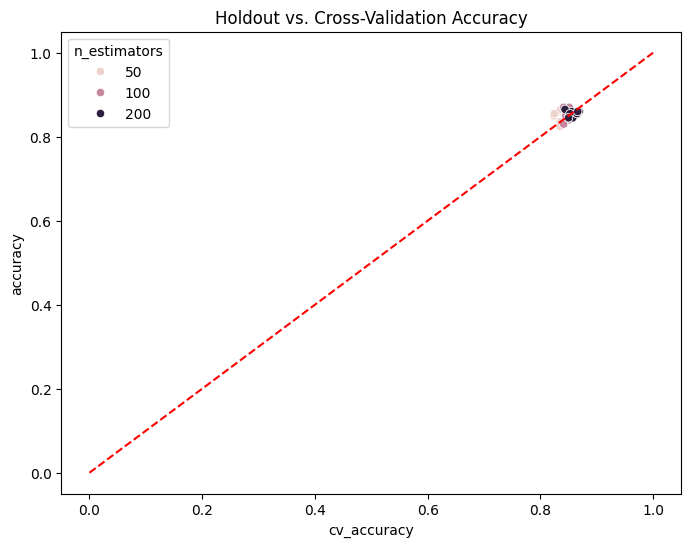


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.014142
100    0.013884
200    0.006539
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.012039
20.0    0.013098
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.008711
5    0.013721
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.012677
sqrt    0.012677
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.012536
2    0.011339
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
100    6
Name: count, dtype: int64
max_depth: max_depth
20.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    8
Name: count, dtype: int64
max_features: max_features
sqrt    5
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    6
Name: count, dtype: int64

Best model max_depth: None


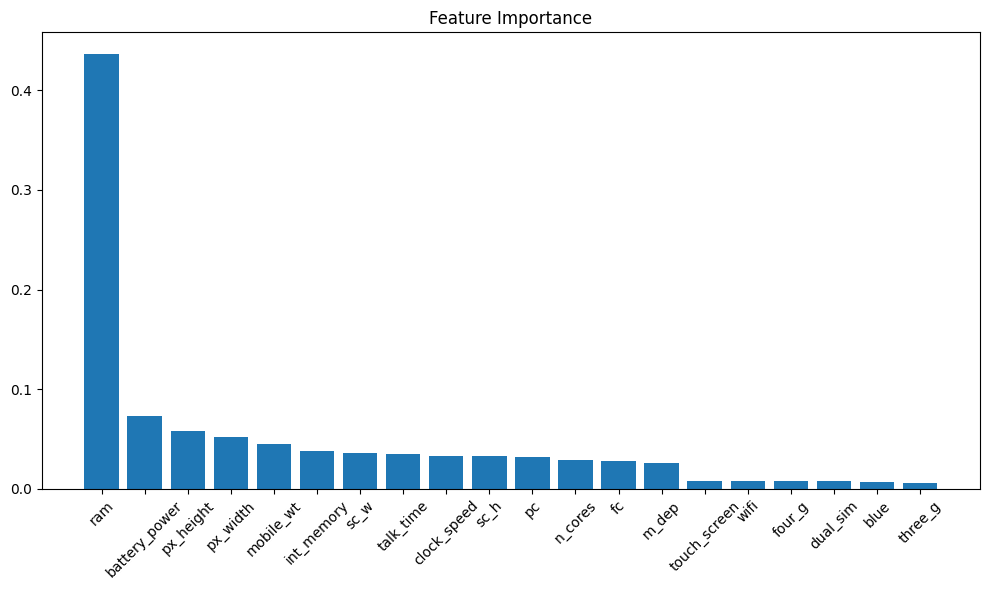

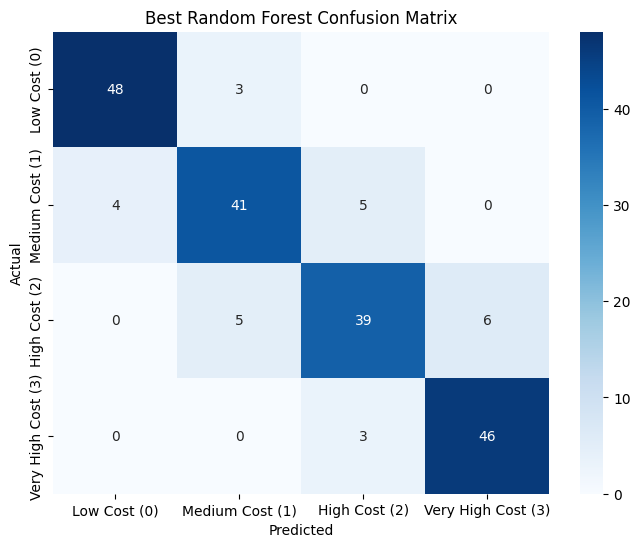


Classification Report for Best Model:
                    precision    recall  f1-score   support

      Low Cost (0)       0.92      0.94      0.93        51
   Medium Cost (1)       0.84      0.82      0.83        50
     High Cost (2)       0.83      0.78      0.80        50
Very High Cost (3)       0.88      0.94      0.91        49

          accuracy                           0.87       200
         macro avg       0.87      0.87      0.87       200
      weighted avg       0.87      0.87      0.87       200



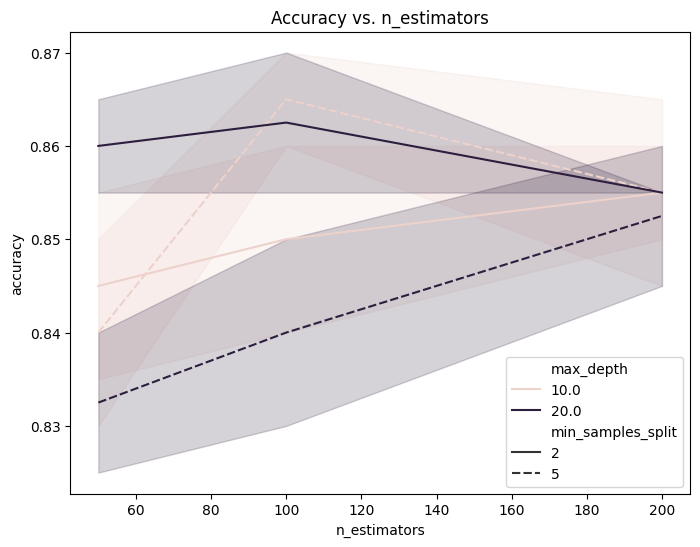

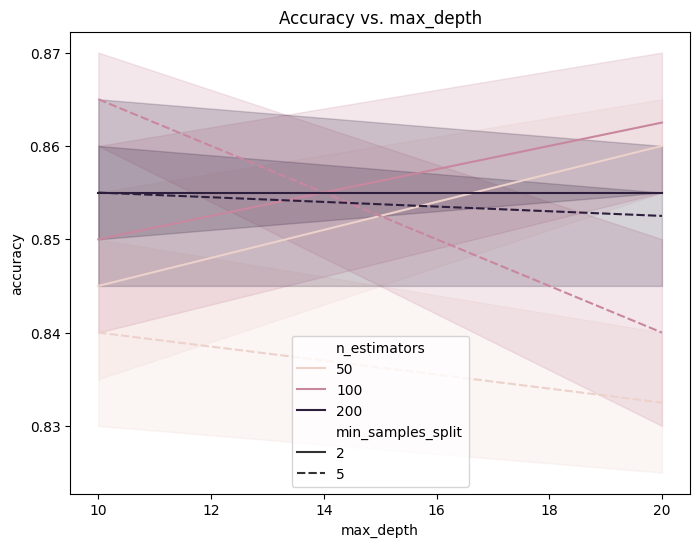

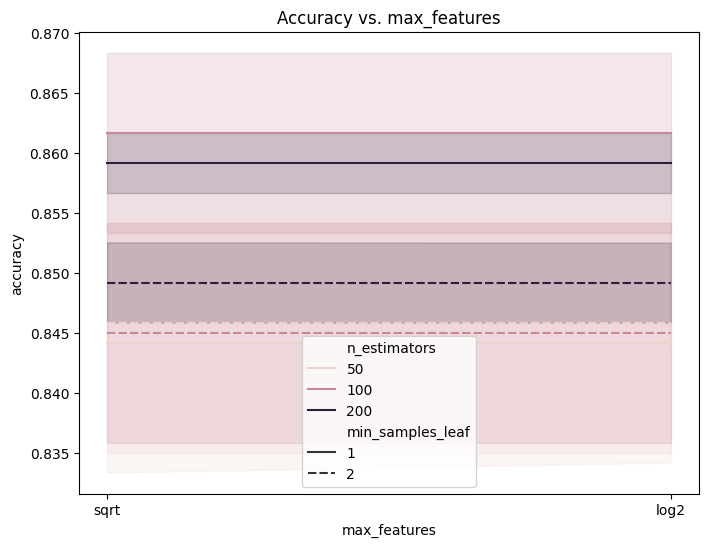


=== Experiments: Scaling=True, Fraction=1.0 ===

Dataset size: 2000, Training samples: 1600, Testing samples: 400

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.88, F1-Score: 0.88, ROC-AUC: 0.98, CV Accuracy: 0.86
Training Time: 0.33s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.86, F1-Score: 0.86, ROC-AUC: 0.98, CV Accuracy: 0.86
Training Time: 0.28s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.88, F1-Score: 0.88, ROC-AUC: 0.98, CV Accuracy: 0.86
Training Time: 0.28s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.86, F1-Score: 0.86, ROC-AUC: 0.98, CV Accuracy: 0.86
Training Time: 0.25s, Prediction Time: 0.02s

T

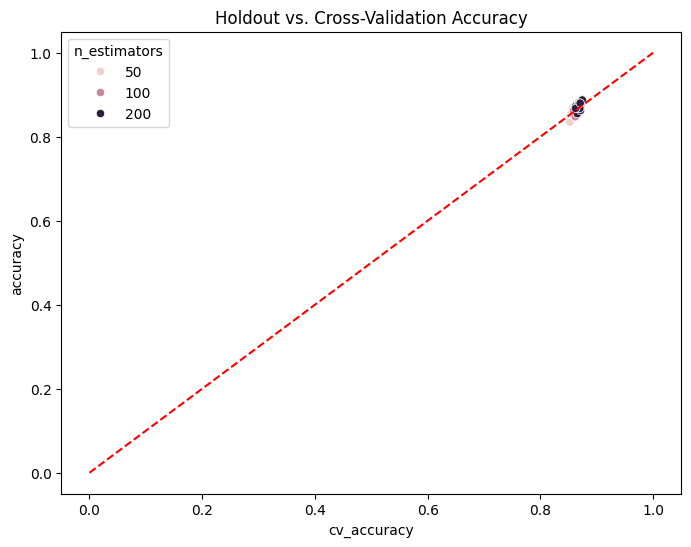


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.013193
100    0.010581
200    0.009286
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.010876
20.0    0.006703
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.013910
5    0.009152
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.011809
sqrt    0.011809
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.012400
2    0.011134
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
200    4
Name: count, dtype: int64
max_depth: max_depth
20.0    2
Name: count, dtype: int64
min_samples_split: min_samples_split
2    8
Name: count, dtype: int64
max_features: max_features
sqrt    5
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    8
Name: count, dtype: int64

Best model max_depth: 20


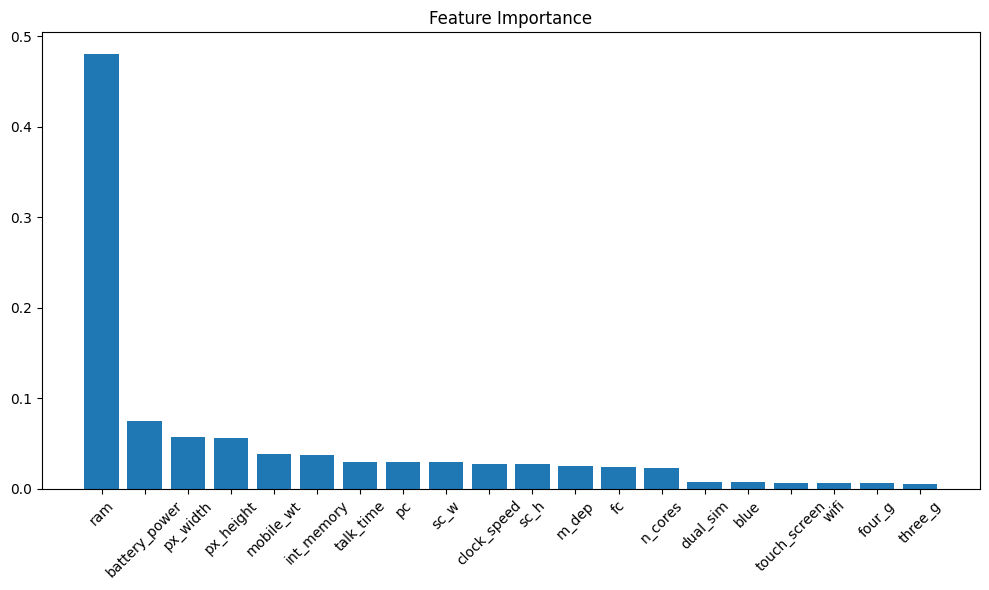

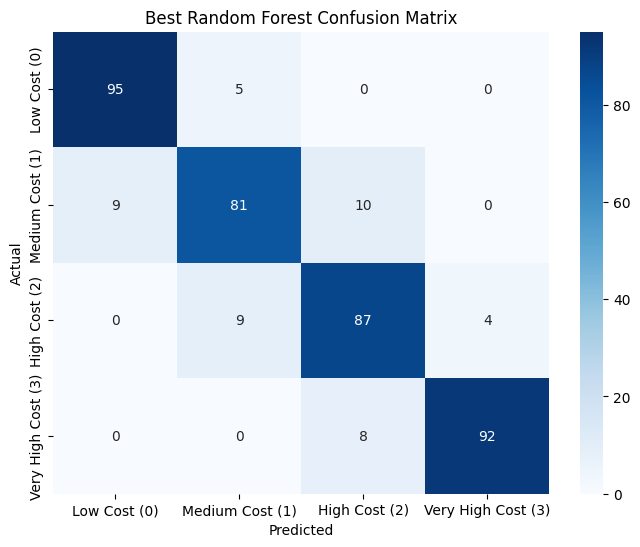


Classification Report for Best Model:
                    precision    recall  f1-score   support

      Low Cost (0)       0.91      0.95      0.93       100
   Medium Cost (1)       0.85      0.81      0.83       100
     High Cost (2)       0.83      0.87      0.85       100
Very High Cost (3)       0.96      0.92      0.94       100

          accuracy                           0.89       400
         macro avg       0.89      0.89      0.89       400
      weighted avg       0.89      0.89      0.89       400



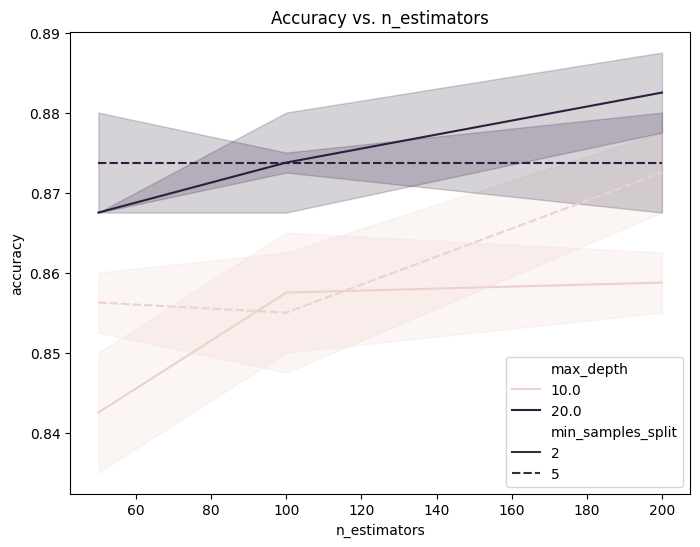

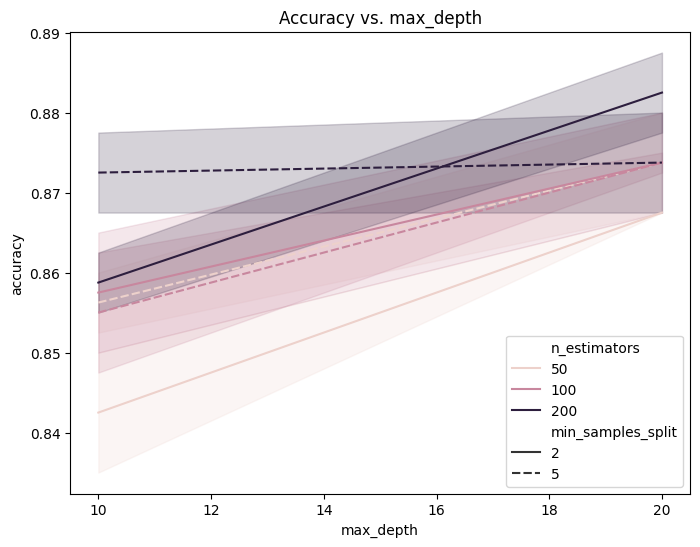

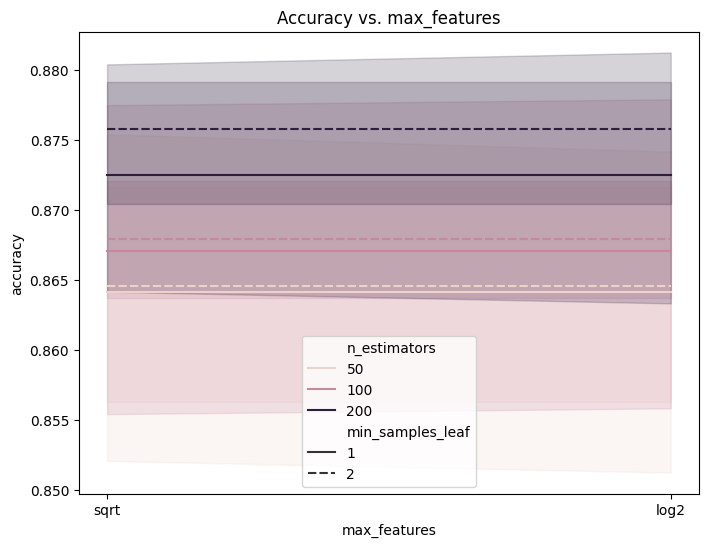


=== Experiments: Scaling=False, Fraction=0.5 ===

Dataset size: 1000, Training samples: 800, Testing samples: 200

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.85, F1-Score: 0.85, ROC-AUC: 0.97, CV Accuracy: 0.82
Training Time: 0.37s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.86, F1-Score: 0.87, ROC-AUC: 0.97, CV Accuracy: 0.84
Training Time: 0.30s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.85, F1-Score: 0.85, ROC-AUC: 0.97, CV Accuracy: 0.82
Training Time: 0.28s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.86, F1-Score: 0.87, ROC-AUC: 0.97, CV Accuracy: 0.84
Training Time: 0.24s, Prediction Time: 0.02s

T

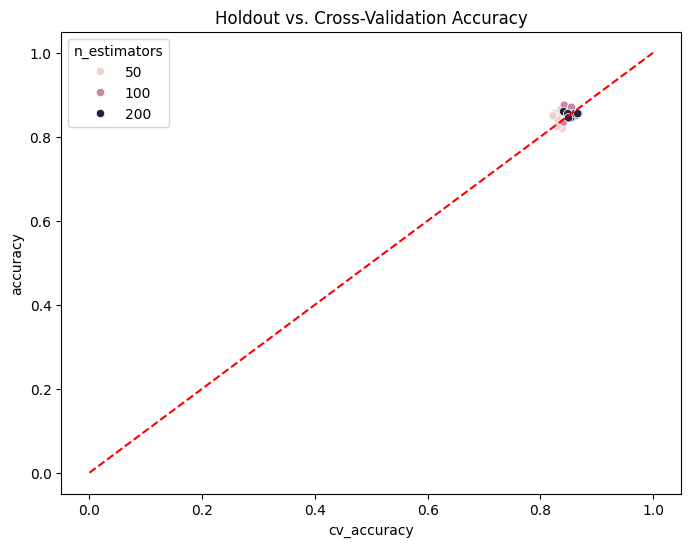


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.014867
100    0.012590
200    0.004872
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.013043
20.0    0.012158
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.007908
5    0.013628
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.01236
sqrt    0.01236
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.012627
2    0.011102
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
100    6
Name: count, dtype: int64
max_depth: max_depth
20.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    8
Name: count, dtype: int64
max_features: max_features
sqrt    5
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    6
Name: count, dtype: int64

Best model max_depth: 10


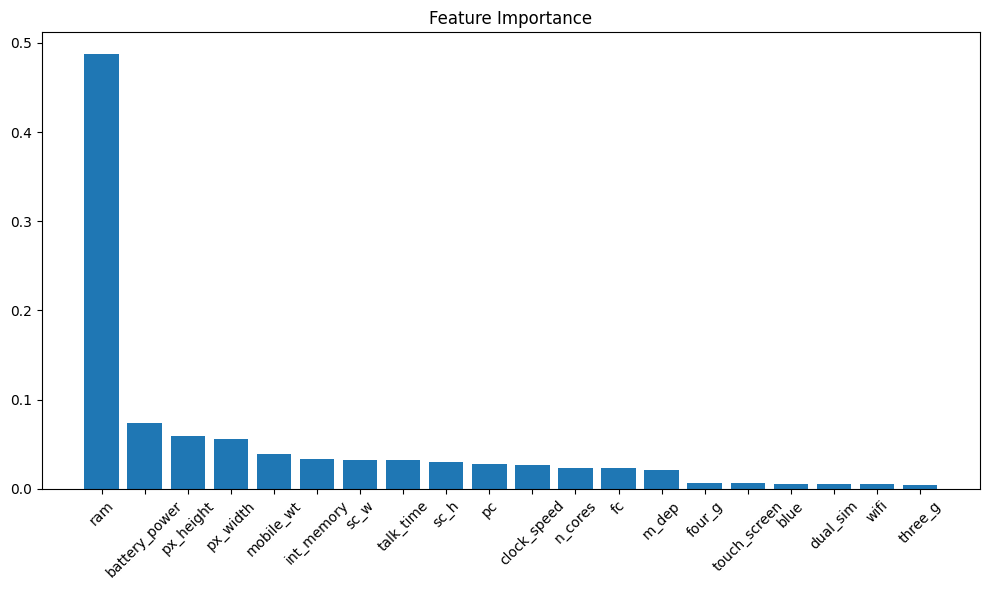

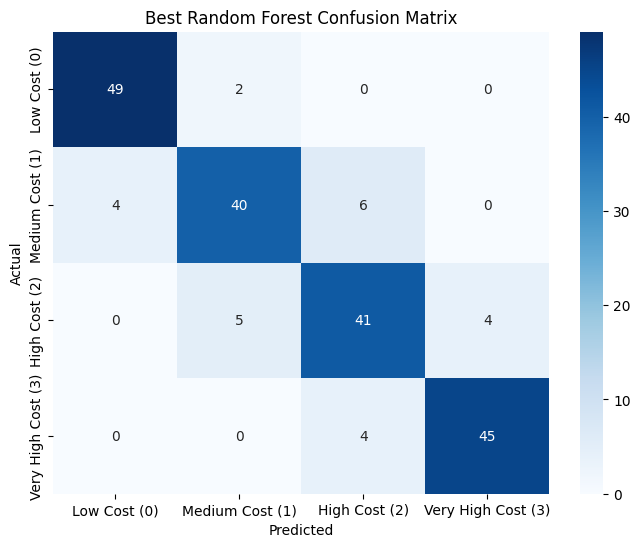


Classification Report for Best Model:
                    precision    recall  f1-score   support

      Low Cost (0)       0.92      0.96      0.94        51
   Medium Cost (1)       0.85      0.80      0.82        50
     High Cost (2)       0.80      0.82      0.81        50
Very High Cost (3)       0.92      0.92      0.92        49

          accuracy                           0.88       200
         macro avg       0.87      0.87      0.87       200
      weighted avg       0.87      0.88      0.87       200



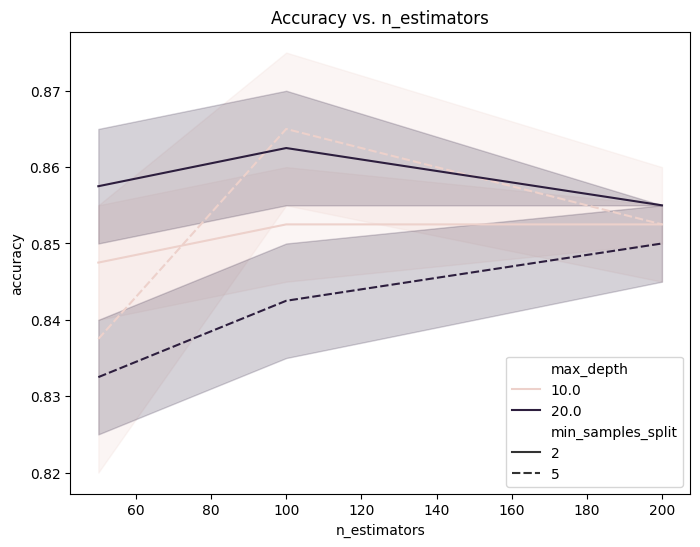

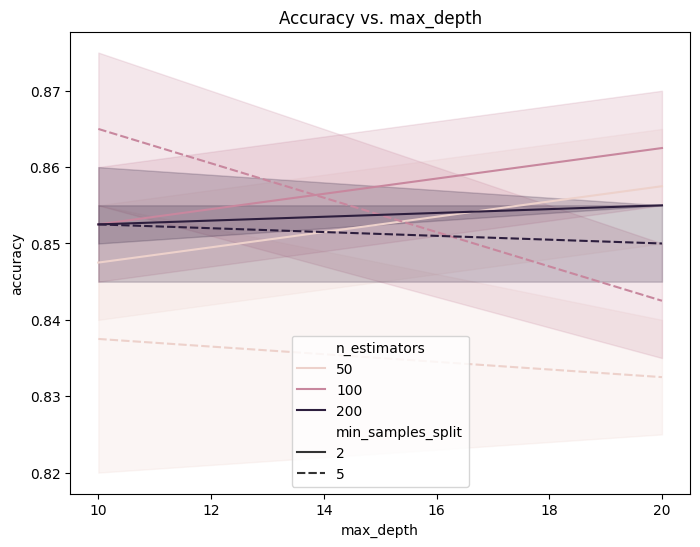

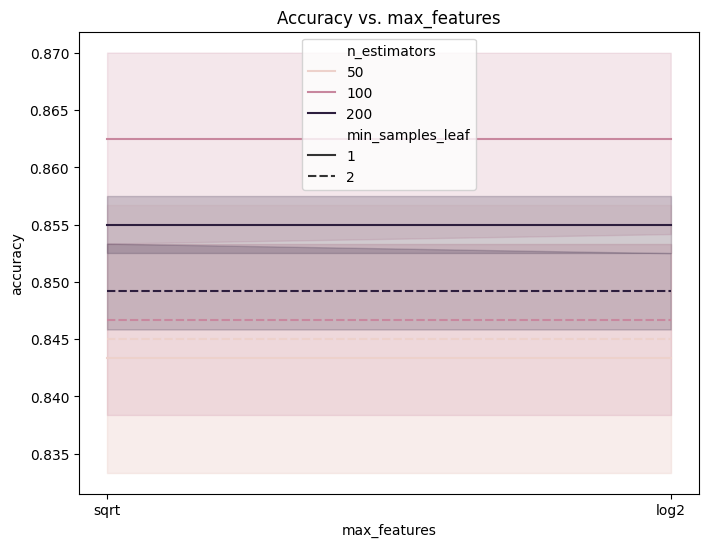


=== Experiments: Scaling=False, Fraction=1.0 ===

Dataset size: 2000, Training samples: 1600, Testing samples: 400

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.88, F1-Score: 0.87, ROC-AUC: 0.98, CV Accuracy: 0.86
Training Time: 0.33s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.86, F1-Score: 0.86, ROC-AUC: 0.98, CV Accuracy: 0.86
Training Time: 0.37s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.88, F1-Score: 0.87, ROC-AUC: 0.98, CV Accuracy: 0.86
Training Time: 0.40s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.86, F1-Score: 0.86, ROC-AUC: 0.98, CV Accuracy: 0.86
Training Time: 0.40s, Prediction Time: 0.01s



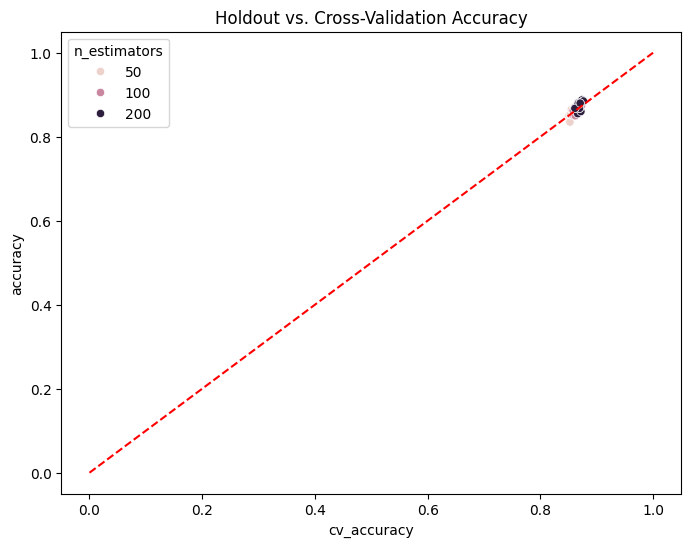


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.013547
100    0.010757
200    0.009640
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.010484
20.0    0.006847
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.014218
5    0.009152
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.012003
sqrt    0.012003
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.012255
2    0.011711
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
200    4
Name: count, dtype: int64
max_depth: max_depth
20.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    6
Name: count, dtype: int64
max_features: max_features
sqrt    5
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    6
Name: count, dtype: int64

Best model max_depth: None


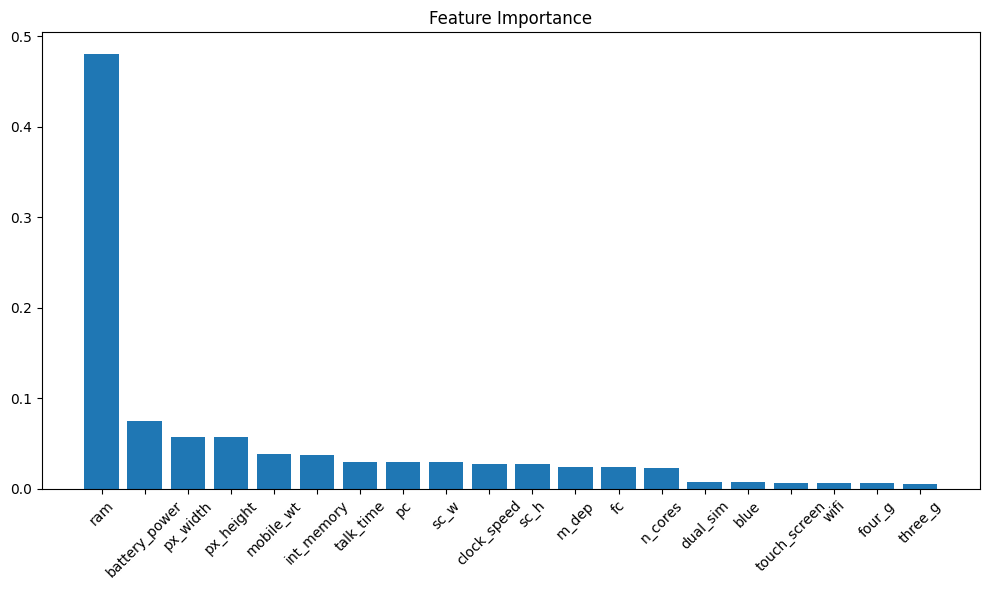

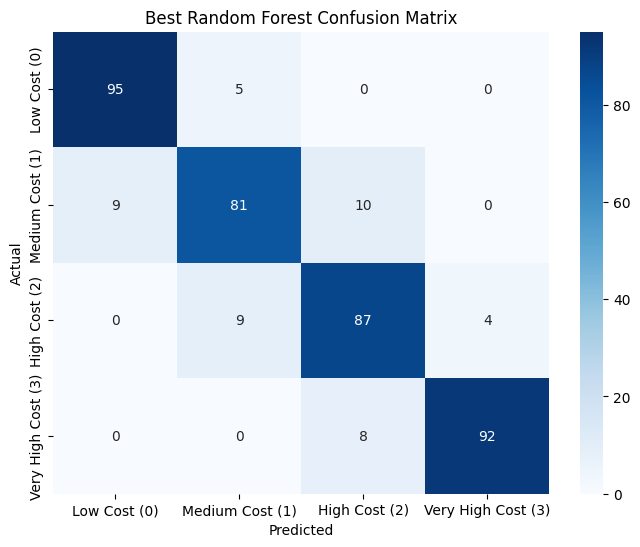


Classification Report for Best Model:
                    precision    recall  f1-score   support

      Low Cost (0)       0.91      0.95      0.93       100
   Medium Cost (1)       0.85      0.81      0.83       100
     High Cost (2)       0.83      0.87      0.85       100
Very High Cost (3)       0.96      0.92      0.94       100

          accuracy                           0.89       400
         macro avg       0.89      0.89      0.89       400
      weighted avg       0.89      0.89      0.89       400



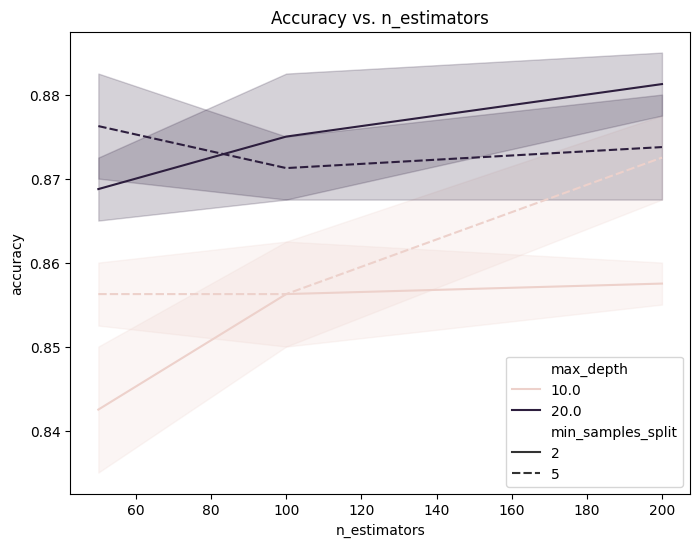

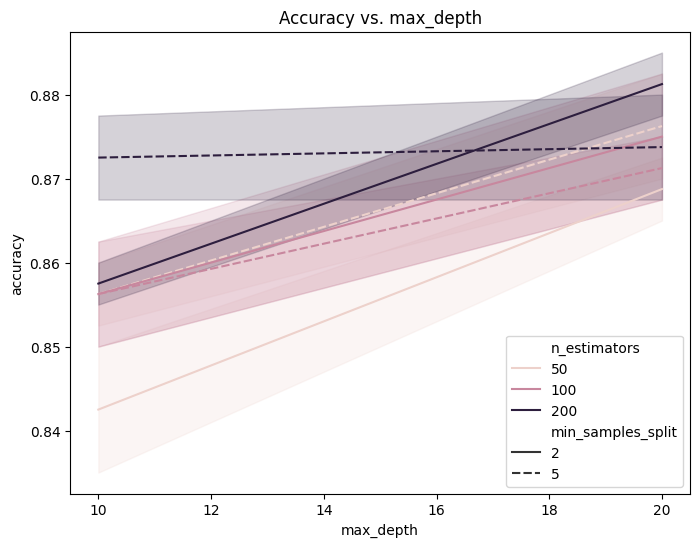

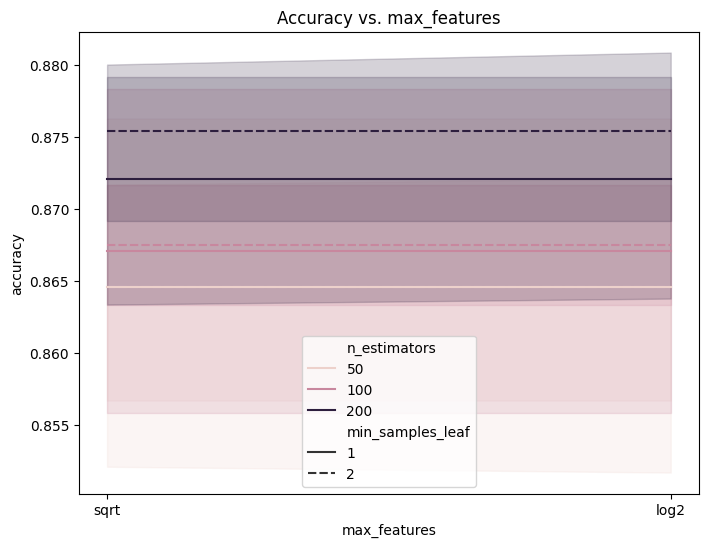

In [5]:

# Cell 5: Visualization and Analysis
def plot_feature_importance(model, feature_cols):
    """Plot feature importances of the Random Forest model."""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_cols[i] for i in indices], rotation=45)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('rf_feature_importance_mobile.png')
    plt.show()

def compare_holdout_cv(results_df):
    """Compare holdout and cross-validation accuracies."""
    results_df['holdout_cv_diff'] = results_df['accuracy'] - results_df['cv_accuracy']
    print("\nHoldout vs. CV Accuracy Difference:\n", results_df[['accuracy', 'cv_accuracy', 'holdout_cv_diff']].describe())
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=results_df, x='cv_accuracy', y='accuracy', hue='n_estimators')
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.title('Holdout vs. Cross-Validation Accuracy')
    plt.savefig('rf_holdout_vs_cv_mobile.png')
    plt.show()

def analyze_parameter_sensitivity(results_df):
    """Analyze sensitivity of accuracy to parameter settings."""
    print("\nParameter Sensitivity (Std of Accuracy):")
    for param in ['n_estimators', 'max_depth', 'min_samples_split', 'max_features', 'min_samples_leaf']:
        grouped = results_df.groupby(param)['accuracy'].std()
        print(f"{param}:\n{grouped}")

def summarize_best_models(results_df, top_n=5):
    """Summarize top N models by accuracy."""
    top_models = results_df.nlargest(top_n, 'accuracy')[['n_estimators', 'max_depth', 'min_samples_split', 'max_features', 'min_samples_leaf', 'accuracy', 'f1_score', 'roc_auc', 'cv_accuracy', 'training_time']]
    print("\nTop 5 Models:\n", top_models)
    top_models.to_csv('rf_top_models_mobile.csv', index=False)

def identify_trends(results_df):
    """Identify common parameter values in top 10 models."""
    print("\nMost Common Parameters in Top 10 Models:")
    top_10 = results_df.nlargest(10, 'accuracy')
    for param in ['n_estimators', 'max_depth', 'min_samples_split', 'max_features', 'min_samples_leaf']:
        print(f"{param}: {top_10[param].value_counts().head(1)}")

def visualize_and_save_results(results, X_train, y_train, X_test, y_test, class_names, feature_cols):
    """Visualize results, save to CSV, and generate report-ready summaries.
    Includes confusion matrix, classification report, parameter sensitivity, and feature importance.
    """
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    print("\nSummary of Results:\n", results_df)
    print("\nmax_depth values:\n", results_df['max_depth'].value_counts(dropna=False))
    
    # Additional analyses
    summarize_best_models(results_df)
    compare_holdout_cv(results_df)
    analyze_parameter_sensitivity(results_df)
    identify_trends(results_df)
    
    # Save results
    results_df.to_csv("rf_results_mobile.csv", index=False)
    
    # Find best model
    best_idx = results_df['accuracy'].idxmax()
    max_depth_value = results_df.loc[best_idx]['max_depth']
    # Convert NaN to None for max_depth
    if pd.isna(max_depth_value):
        max_depth_value = None
    else:
        max_depth_value = int(max_depth_value) if max_depth_value is not None else None
    
    print(f"\nBest model max_depth: {max_depth_value}")
    
    best_rf = RandomForestClassifier(
        n_estimators=int(results_df.loc[best_idx]['n_estimators']),
        max_depth=max_depth_value,
        min_samples_split=int(results_df.loc[best_idx]['min_samples_split']),
        max_features=results_df.loc[best_idx]['max_features'],
        min_samples_leaf=int(results_df.loc[best_idx]['min_samples_leaf']),
        random_state=42,
        class_weight='balanced'
    )
    best_rf.fit(X_train, y_train)
    predictions = best_rf.predict(X_test)
    
    # Feature importance
    plot_feature_importance(best_rf, feature_cols)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Best Random Forest Confusion Matrix')
    plt.savefig('rf_confusion_matrix_mobile.png')
    plt.show()
    
    # Classification report
    print("\nClassification Report for Best Model:")
    print(classification_report(y_test, predictions, target_names=class_names))
    
    # Plot accuracy vs. n_estimators
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='n_estimators', y='accuracy', hue='max_depth', style='min_samples_split')
    plt.title('Accuracy vs. n_estimators')
    plt.savefig('rf_accuracy_vs_estimators_mobile.png')
    plt.show()
    
    # Plot accuracy vs. max_depth
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='max_depth', y='accuracy', hue='n_estimators', style='min_samples_split')
    plt.title('Accuracy vs. max_depth')
    plt.savefig('rf_accuracy_vs_max_depth_mobile.png')
    plt.show()
    
    # Plot accuracy vs. max_features
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='max_features', y='accuracy', hue='n_estimators', style='min_samples_leaf')
    plt.title('Accuracy vs. max_features')
    plt.savefig('rf_accuracy_vs_max_features_mobile.png')
    plt.show()

# Cell 6: Main Execution
# Define class names
class_names = ['Low Cost (0)', 'Medium Cost (1)', 'High Cost (2)', 'Very High Cost (3)']

# Run experiments for different dataset sizes and scaling
for scaling in [True, False]:
    for frac in [0.5, 1.0]:
        print(f"\n=== Experiments: Scaling={scaling}, Fraction={frac} ===")
        X_train, X_test, y_train, y_test, feature_cols = preprocess_data(df, scaling=scaling, sample_fraction=frac)
        results = run_rf_experiments(X_train, y_train, X_test, y_test, class_names, feature_cols)
        # Save results with unique filename
        visualize_and_save_results(results, X_train, y_train, X_test, y_test, class_names, feature_cols)
        results_df = pd.DataFrame(results)
        results_df.to_csv(f"rf_results_mobile_scaling_{scaling}_frac_{frac}.csv", index=False)